In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng

In [15]:
def groundTruth(input):
    #out = np.sin(16*input)  *  np.exp(-5*input**2)
    out = np.tanh(10*input)
    return(out)

def rngWeights(M, sigmaWeights, sigmaBiases):    # make up the random parameters for the input-to-hidden linear mapping.
    W = rng.normal(0,sigmaWeights,(M)) #yes, weird in that there's only 1 input dimension, built in. Sucks...
    B = rng.normal(0,sigmaBiases,(M))
    return (W,B)

def doDesignMatrix(W,B,x):    # projection of x, using those W,B and a nonlinearity: Bishop denotes this Phi
    Phi = np.maximum(0,np.outer(x,W) + B)  # the nonlinearity here is ReLU.
    #Phi = np.tanh(np.outer(x,W) + B)
    return(Phi)

## size of network, data, etc

In [23]:
M = 100   # number of basis functions (a.k.a. hidden units)
N = 10  # number of data items
Ntest = 100 # number of points to plot when showing the plotted lines
Nensemble = 500 # number of random networks used in ensembles 

#xData = 0.5*(1-2*rng.random((N,1)))
#xData = 0.5*np.array([-1,-.9,-.8,-.7,-.6,1,.9,.8,.7,.6]).reshape(N,1)
xData = 0.5*np.array([-2,-1.9,-1.8,-1.7,-1.6,2,1.9,1.8,1.7,1.6]).reshape(N,1)
         
yData = groundTruth(xData)
x = np.linspace(-1,1,Ntest)#.reshape(Ntest,1)

## regularisers and initial weights
Nb. precision is just inverse variance.

#### hid-to-output map:
 * $\alpha$ is precision of the Gaussian prior we're putting on output weights. Higher values correspond to stronger belief that weights are close to zero.
 * $\beta$ is precision of the noise on observations of targets. Eg: if assumed noise has stddev of 0.01, precision is 10,000

 * for vanilla MoorePenrose, set $\alpha \sim 0$ (e.g. 0.001) and $\beta = 1$.
 
#### input-to-hid map:
Weights and biases chosen from zero-mean Gaussians. We set standard deviations $\sigma$ for those.

In [24]:
# For the hid-to-output mapping:
alpha = 1.0 
beta = 10000.0

# For the input-to-hidden mapping:
sigmaWeights = 1.0
sigmaBiases  = 1.0

### Here is the magic linalg incantation

In [25]:
def BayesLinearRegression(W,B,alpha,beta,xData,xQuery):
    Phi = doDesignMatrix(W,B,xData)
    invS = alpha*np.eye(M) + beta*np.dot(Phi.transpose(),Phi)
    S = np.linalg.inv(invS)
    regMoorePenrose = beta*np.dot(S, Phi.transpose()) #nb. the beta here "undoes" the one inside invS
    wLMS = np.dot(regMoorePenrose, yData)
    phi = doDesignMatrix(W,B,xQuery)
    y = np.dot(phi,wLMS)
    sig2 = 1/beta + np.diag(np.dot(np.dot(phi, S), phi.transpose())).reshape(y.shape) 
    return (y, sig2) 

# 1. comparing 'ELM' ensembles, with and without Bayesian errorbars 

## first, a simple ensemble of random 2 layer networks
OMG, "extreme learning machine" is such as ridiculous name for this trivial thing!

I'm making an ensemble of random 2-layer networks here. 

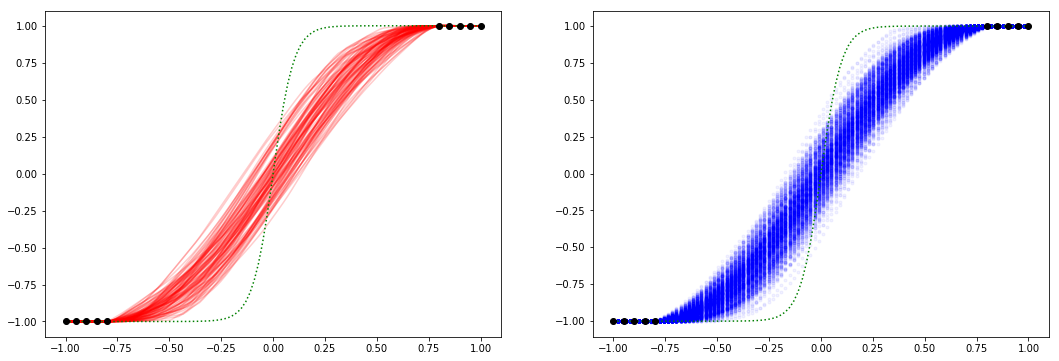

In [26]:
ys = []
for i in range(Nensemble):
    W,B = rngWeights(M,sigmaWeights,sigmaBiases)
    y, sig2 = BayesLinearRegression(W,B,alpha,beta,xData,x)
    ys.append(y)
    
fig=plt.figure(figsize=(18, 6))
LHS, RHS = plt.subplot(121), plt.subplot(122)

for y in ys[0:min(100,Nensemble)]: 
    LHS.plot(x,y,'-r',alpha=0.2)
LHS.plot(x,groundTruth(x),':g',xData,yData,'ok')

for y in ys: 
    RHS.plot(x,y,'.b',alpha=0.05)
RHS.plot(x,groundTruth(x),':g',xData,yData,'ok')

### and let's find the empirical sample mean and variance, and show the 2 $\sigma$ "error bars"

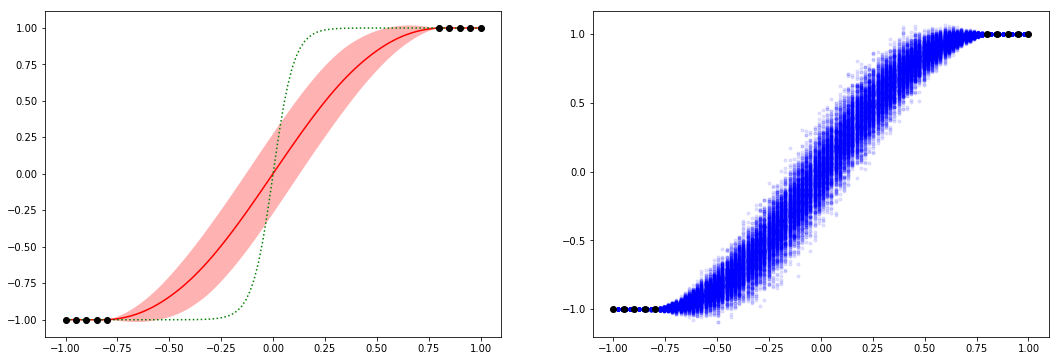

In [27]:
empMean, empSig2 = np.zeros(ys[0].shape), np.zeros(ys[0].shape)
for y in ys:    empMean = empMean + y/len(ys)
for y in ys:    empSig2 = empSig2 + np.power(empMean - y, 2) / len(ys)

fig=plt.figure(figsize=(18, 6))
LHS, RHS = plt.subplot(121), plt.subplot(122)

LHS.plot(x,empMean,'-r',alpha=1)
upper = np.ravel(empMean + 2*np.sqrt(empSig2))
lower = np.ravel(empMean - 2*np.sqrt(empSig2))
LHS.fill_between(x, lower, upper, facecolor='red', interpolate=True, alpha=.3)
LHS.plot(x,groundTruth(x),':g',xData,yData,'ok')

for i in range(Nensemble):
    RHS.plot(x,rng.normal(np.ravel(empMean),np.ravel(np.sqrt(empSig2))),'.b',alpha=.1)
RHS.plot(xData,yData,'ok')

## now try the Bayesian Way

### first, just try one random network, but showing its 'Bayesian' predictions
Q: is it much different from the ensemble version?

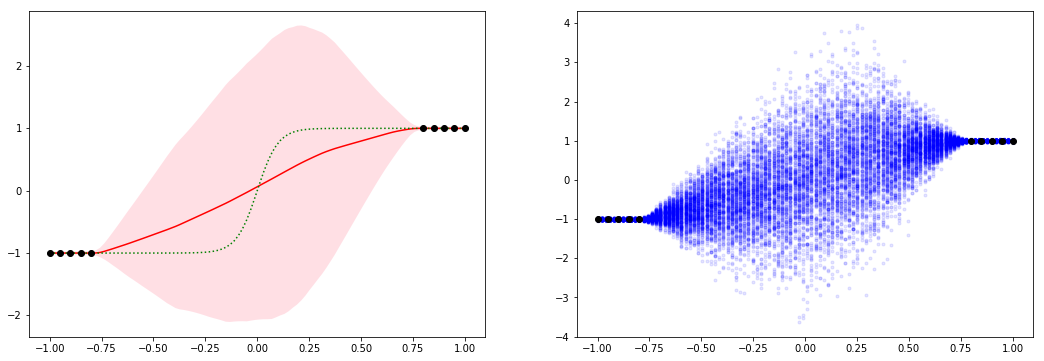

In [29]:
fig=plt.figure(figsize=(18, 6))
LHS, RHS = plt.subplot(121), plt.subplot(122)

W,B = rngWeights(M,sigmaWeights,sigmaBiases)
y, sig2 = BayesLinearRegression(W,B,alpha,beta,xData,x)

upper = np.ravel(y + 2*np.sqrt(sig2))
lower = np.ravel(y - 2*np.sqrt(sig2))
LHS.fill_between(np.ravel(x), lower, upper, facecolor='pink', interpolate=True, alpha=.5)
LHS.plot(x,y,'-r',alpha=1)

# for the RHS, we just draw samples i.i.d at each x value in linspace
for i in range(200):
    z = rng.normal(y,np.sqrt(sig2))
    RHS.plot(x,z,'.b',alpha= 0.1)
    
LHS.plot(x,groundTruth(x),':g',xData,yData,'ok')
RHS.plot(xData,yData,'ok')

### and now an ensemble of Bayesians
We do an ensemble of ELMS, each one being given a Bayesian posterior, so the full posterior is a uniform mixture of Gaussians. Since that's hard to visualise I draw heaps of samples from it (which is easy).

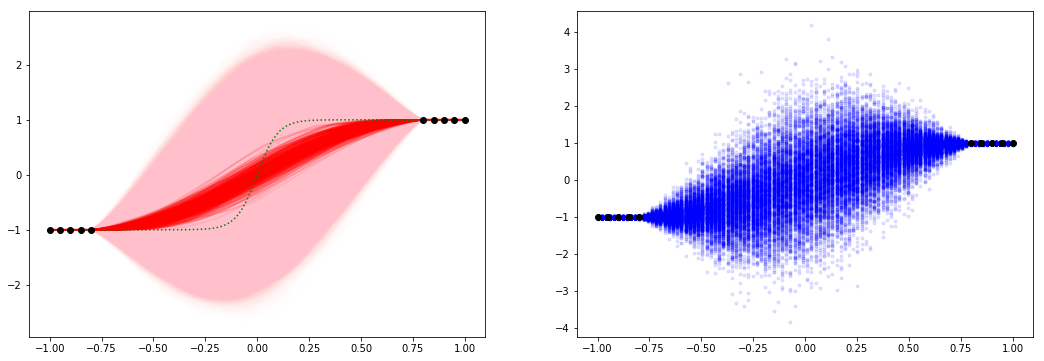

In [30]:

fig=plt.figure(figsize=(18, 6))
LHS, RHS = plt.subplot(121), plt.subplot(122)

for i in range(Nensemble):
    W,B = rngWeights(M,sigmaWeights,sigmaBiases)
    y, sig2 = BayesLinearRegression(W,B,alpha,beta,xData,x)
    
    upper = np.ravel(y + 2*np.sqrt(sig2))
    lower = np.ravel(y - 2*np.sqrt(sig2))
    LHS.fill_between(np.ravel(x), lower, upper, facecolor='pink', interpolate=True, alpha=.0025)
    LHS.plot(x,y,'-r',alpha=.1)

    # for the RHS, we just draw samples i.i.d at each x value in linspace
    z = rng.normal(y, np.sqrt(sig2))
    RHS.plot(x,z,'.b',alpha= 0.1)
    
LHS.plot(x,groundTruth(x),':g',xData,yData,'ok')
RHS.plot(xData,yData,'ok')

# 2. Testing an alternative setting for the first layer weights and biases
Preamble: we don't know how to set the typical bias weight size relative to the other weights size. Also: ignoring the biases, it doesn't matter what scale we choose for input-to-hidden weights, because the hidden-to-output ones will just learn to "undo" the scaling anyway.

So let's L2-normalise the input-to-hidden weights, so they only vary in terms of directions in input space.
The bias is then precisely the distance from the origin (in input space now) where the ReLU non-linearity will kick in.
This suggests we should just set it uniformly over the domain of inputs we're interested in. (Nb: not just the data, but the test domain too, obviously).

This removes the arbitrariness of setting a typical size for the bias weight distribution.

Just going to try this out.

In [32]:
def ALTrngWeights(M):    # make up the random parameters for the input-to-hidden linear mapping.
    W = 2.*rng.randint(0,2,(M)) - 1. # "normalisation" in 1d makes them all 1, or -1!!
    B = 2. * (2*rng.random(M) -1)
    return (W,B)

[Text(0,0,'-1.0'), Text(0,0,'0'), Text(0,0,'1.0')]

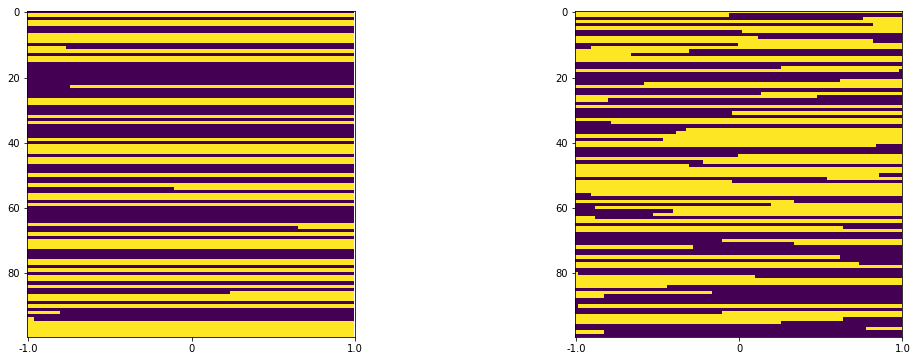

In [36]:
sigmaWeights = 1.0
sigmaBiases = 10.0


fig=plt.figure(figsize=(18,6))
# LHS uses guesses for the input-to-hidden mapping weight/bias distributions
LHS, RHS = plt.subplot(121), plt.subplot(122)

W,B = rngWeights(M,sigmaWeights,sigmaBiases)
LHS.imshow(doDesignMatrix(W,B,x).transpose()>0)
LHS.set_xticks([0,len(x)/2,len(x)])
LHS.set_xticklabels([x[0],'0',x[-1]])

# ...vs RHS with no free params to set
W,B = ALTrngWeights(M)
RHS.imshow(doDesignMatrix(W,B,x).transpose()>0)
RHS.set_xticks([0,len(x)/2,len(x)])
RHS.set_xticklabels([x[0],'0',x[-1]])

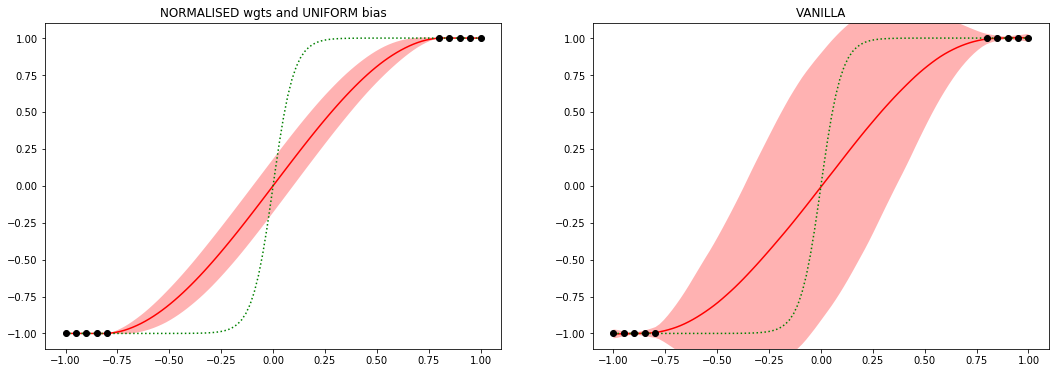

In [37]:
ysBASE, ysCOMPARE = [], []
for i in range(Nensemble):
    # standard approach
    W,B = rngWeights(M,sigmaWeights,sigmaBiases)    
    y, sig2 = BayesLinearRegression(W,B,alpha,beta,xData,x)
    ysBASE.append(y)

    # ALT approach
    W,B = ALTrngWeights(M)
    y, sig2 = BayesLinearRegression(W,B,alpha,beta,xData,x)
    ysCOMPARE.append(y)


# make a plot
fig=plt.figure(figsize=(18, 6))
LHS, RHS = plt.subplot(121), plt.subplot(122)

#LHS is my idea for comparison
empMean, empSig2 = np.zeros(ys[0].shape), np.zeros(ys[0].shape)
for y in ysCOMPARE:    empMean = empMean + y/len(ys)
for y in ysCOMPARE:    empSig2 = empSig2 + np.power(empMean - y, 2) / len(ys)
LHS.plot(x,empMean,'-r',alpha=1)
upper = np.ravel(empMean + 2*np.sqrt(empSig2))
lower = np.ravel(empMean - 2*np.sqrt(empSig2))
LHS.fill_between(x, lower, upper, facecolor='r', interpolate=True, alpha=.3)
LHS.plot(x,groundTruth(x),':g',xData,yData,'ok')
LHS.set_title('NORMALISED wgts and UNIFORM bias')

#RHS is vanilla
empMean, empSig2 = np.zeros(ys[0].shape), np.zeros(ys[0].shape)
for y in ysBASE:    empMean = empMean + y/len(ys)
for y in ysBASE:    empSig2 = empSig2 + np.power(empMean - y, 2) / len(ys)
RHS.plot(x,empMean,'-r',alpha=1)
upper = np.ravel(empMean + 2*np.sqrt(empSig2))
lower = np.ravel(empMean - 2*np.sqrt(empSig2))
RHS.fill_between(x, lower, upper, facecolor='red', interpolate=True, alpha=.3)
RHS.plot(x,groundTruth(x),':g',xData,yData,'ok')
RHS.set_title('VANILLA')
z=RHS.axis( LHS.axis()) # make the limits of RHS pic same as the LHS one.